make dataset 1 : https://www.kaggle.com/datasets/kaushil268/disease-prediction-using-machine-learning/data

dataset 2 : https://www.kaggle.com/datasets/itachi9604/disease-symptom-description-dataset

dataset 3 : https://data.mendeley.com/datasets/2cxccsxydc/1

# 📌 IMPORT LIBRARY

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from collections import Counter

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# 📌 LOAD DATASET

In [2]:
df1 = pd.read_csv('Dataset/DF1.csv')
df2 = pd.read_csv('Dataset/DF2.csv')
df3 = pd.read_csv('Dataset\DF3.csv')

print("✔️ Semua dataset berhasil dimuat.\n")

✔️ Semua dataset berhasil dimuat.



# 📌 DATA UNDERSTANDING

In [3]:
def show_symptoms_data(df, df_name):
    print(f"{df_name} info:")
    print(df.info())
    print(f"\n{df_name} sample:")
    print(df.head())

    # Cek kemungkinan kolom gejala tunggal
    possible_symptom_cols = [col for col in df.columns if 'symptom' in col.lower() or 'gejala' in col.lower()]
    
    if len(possible_symptom_cols) == 1:
        col = possible_symptom_cols[0]
        print(f"\n{df_name} - Kolom gejala tunggal: '{col}' sample data:")
        print(df[col].head())
    else:
        # Jika banyak kolom, anggap semua kecuali kolom target adalah gejala (contoh seperti df3)
        target_cols = ['disease', 'diseases', 'Disease']  # bisa diperluas jika perlu
        symptom_cols = [col for col in df.columns if col not in target_cols]
        print(f"\n{df_name} - Kolom gejala ({len(symptom_cols)} kolom), contoh data:")
        print(df[symptom_cols].head())

print("=== DATA UNDERSTANDING ===\n")

show_symptoms_data(df1, "df1")
print("\n-------------------------\n")
show_symptoms_data(df2, "df2")
print("\n-------------------------\n")
show_symptoms_data(df3, "df3")


=== DATA UNDERSTANDING ===

df1 info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Columns: 134 entries, itching to Unnamed: 133
dtypes: float64(1), int64(132), object(1)
memory usage: 5.0+ MB
None

df1 sample:
   itching  skin_rash  nodal_skin_eruptions  continuous_sneezing  shivering  \
0        1          1                     1                    0          0   
1        0          1                     1                    0          0   
2        1          0                     1                    0          0   
3        1          1                     0                    0          0   
4        1          1                     1                    0          0   

   chills  joint_pain  stomach_pain  acidity  ulcers_on_tongue  ...  scurring  \
0       0           0             0        0                 0  ...         0   
1       0           0             0        0                 0  ...         0   
2       0           0             0       

# 📌 EDA (Exploratory Data Analysis)

✅ EDA untuk df1

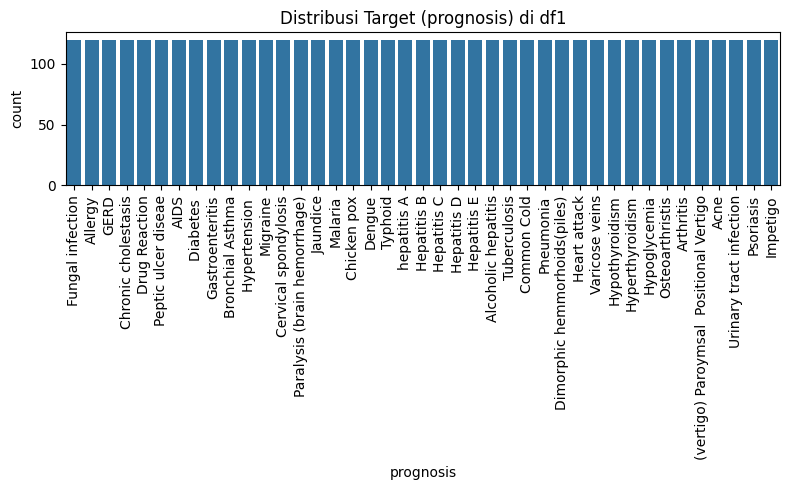

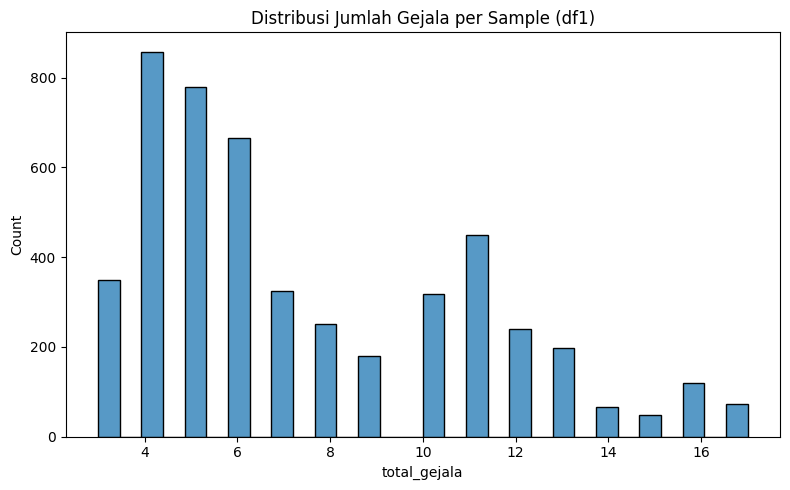

In [4]:
# Distribusi target (prognosis) - df1
plt.figure(figsize=(8, 5))
sns.countplot(data=df1, x='prognosis')
plt.title('Distribusi Target (prognosis) di df1')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Distribusi jumlah gejala - df1
df1['total_gejala'] = df1.drop(columns='prognosis').sum(axis=1)
plt.figure(figsize=(8, 5))
sns.histplot(df1['total_gejala'], bins=30)
plt.title('Distribusi Jumlah Gejala per Sample (df1)')
plt.tight_layout()
plt.show()
df1.drop(columns='total_gejala', inplace=True)


✅ EDA untuk df2

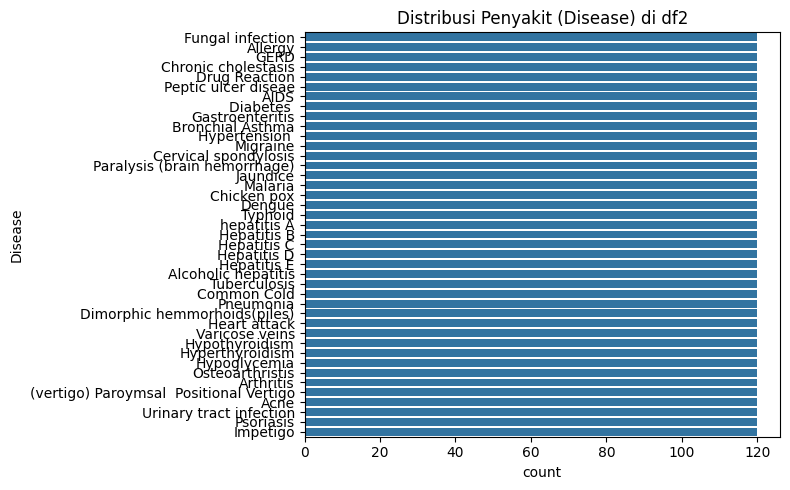

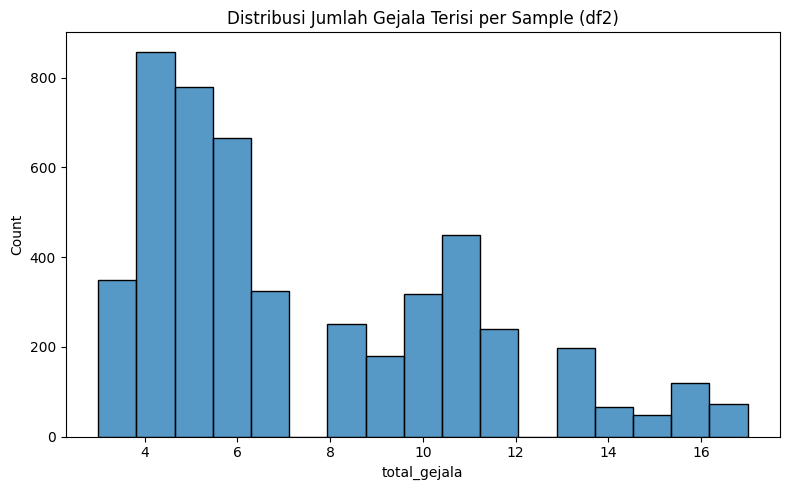

In [5]:
# Jumlah data per penyakit - df2
plt.figure(figsize=(8, 5))
sns.countplot(data=df2, y='Disease', order=df2['Disease'].value_counts().index)
plt.title('Distribusi Penyakit (Disease) di df2')
plt.tight_layout()
plt.show()

# Jumlah gejala yang terisi per sampel - df2
symptom_cols = [f'Symptom_{i}' for i in range(1, 18)]
df2['total_gejala'] = df2[symptom_cols].notna().sum(axis=1)
plt.figure(figsize=(8, 5))
sns.histplot(df2['total_gejala'], bins=17)
plt.title('Distribusi Jumlah Gejala Terisi per Sample (df2)')
plt.tight_layout()
plt.show()
df2.drop(columns='total_gejala', inplace=True)


✅ EDA untuk df3

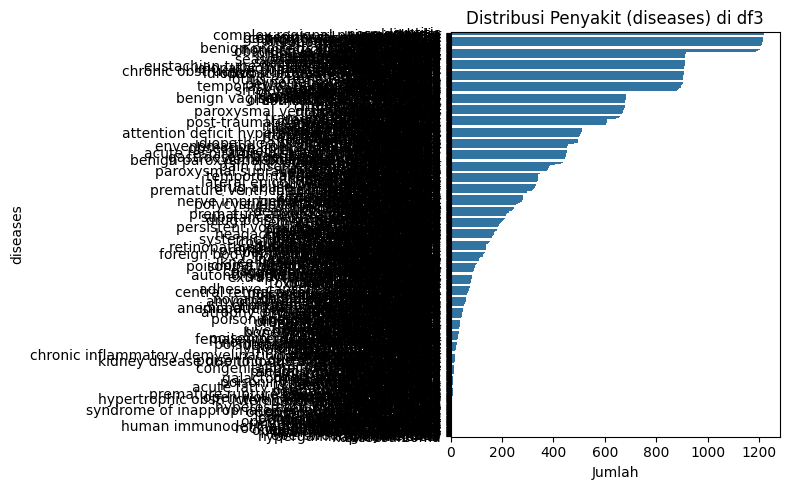

C:\Users\crism\AppData\Local\Temp\ipykernel_18424\623940936.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df3['total_gejala'] = df3[symptom_cols_df3].sum(axis=1)


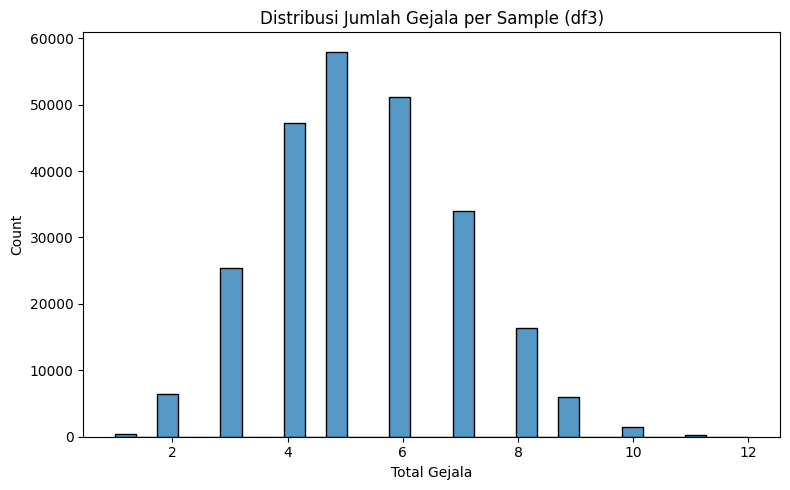

In [6]:
# Cek kolom target df3
has_target = 'diseases' in df3.columns

# Jika ada target, tampilkan distribusi penyakit
if has_target:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df3, y='diseases', order=df3['diseases'].value_counts().index)
    plt.title('Distribusi Penyakit (diseases) di df3')
    plt.xlabel('Jumlah')
    plt.tight_layout()
    plt.show()
else:
    print("❌ Kolom 'diseases' tidak ditemukan di df3.")

# Ambil kolom gejala (semua kecuali 'diseases')
symptom_cols_df3 = [col for col in df3.columns if col != 'diseases']

# Konversi ke numerik dan isi NaN dengan 0
df3[symptom_cols_df3] = df3[symptom_cols_df3].apply(pd.to_numeric, errors='coerce').fillna(0)

# Hitung total gejala per sampel
df3['total_gejala'] = df3[symptom_cols_df3].sum(axis=1)

# Plot distribusi jumlah gejala
plt.figure(figsize=(8, 5))
sns.histplot(df3['total_gejala'], bins=30)
plt.title('Distribusi Jumlah Gejala per Sample (df3)')
plt.xlabel('Total Gejala')
plt.tight_layout()
plt.show()

# Hapus kolom bantu
df3.drop(columns='total_gejala', inplace=True)

# 📌 DATA PREPROCESSING

In [7]:
symptom_columns = df1.columns[:-1].tolist()
df1_filtered = df1.loc[:, ~df1.columns.str.contains('^Unnamed')]

df1_filtered['total_gejala'] = df1_filtered.drop(columns='prognosis').sum(axis=1)
df1_filtered = df1_filtered[df1_filtered['total_gejala'] > 3].drop(columns='total_gejala')

def convert_symptoms_to_onehot(df, symptom_cols, all_symptoms):
    new_df = pd.DataFrame(0, index=df.index, columns=all_symptoms)
    for col in symptom_cols:
        for idx, symptom in df[col].items():
            if pd.notna(symptom) and symptom in all_symptoms:
                new_df.at[idx, symptom] = 1
    new_df['prognosis'] = df['Disease']
    return new_df

df2_onehot = convert_symptoms_to_onehot(df2, [f'Symptom_{i}' for i in range(1, 18)], symptom_columns)
df2_onehot['total_gejala'] = df2_onehot.drop(columns='prognosis').sum(axis=1)
df2_filtered = df2_onehot[df2_onehot['total_gejala'] > 3].drop(columns='total_gejala')

cols_to_use = [col for col in df3.columns if col in symptom_columns]
if 'prognosis' in df3.columns:
    cols_to_use.append('prognosis')

df3_cleaned = df3[cols_to_use].copy()

if 'prognosis' in df3_cleaned.columns:
    df3_cleaned['total_gejala'] = df3_cleaned.drop(columns='prognosis').sum(axis=1)
else:
    df3_cleaned['total_gejala'] = df3_cleaned.sum(axis=1)

df3_filtered = df3_cleaned[df3_cleaned['total_gejala'] > 3].drop(columns='total_gejala')

# 📌 GABUNGKAN SEMUA DATASET

In [8]:
df_combined = pd.concat([df1_filtered, df2_filtered, df3_filtered], ignore_index=True)

print(f"Total data gabungan: {df_combined.shape}")
print(f"Jumlah kolom gejala: {len(symptom_columns)}")

Total data gabungan: (5962, 133)
Jumlah kolom gejala: 133


# 📌 DATA PREPARATION (fitur & target)

In [9]:
X = df_combined[symptom_columns]
y = df_combined['prognosis']

not_nan_idx = y.notnull()
X = X.loc[not_nan_idx]
y = y.loc[not_nan_idx]

X = X.apply(pd.to_numeric, errors='coerce').fillna(0)


# 📌 SPLIT DATA TRAIN & TEST

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ============================
# 📌 POLYNOMIAL FEATURES (degree=2, interaction only)
# ============================
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

print(f"Jumlah fitur asli: {X_train.shape[1]}")
print(f"Jumlah fitur setelah polynomial interaction: {X_train_poly.shape[1]}")

Jumlah fitur asli: 133
Jumlah fitur setelah polynomial interaction: 8911


# 📌 MODEL DEVELOPMENT (Pipeline + Randomized Search)

In [11]:
pipe_no_smote = Pipeline([
    ('feature_sel', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1), threshold='median')),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_dist_no_smote = {
    'clf__n_estimators': [300, 500, 700],
    'clf__max_depth': [30, 50, 70, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['sqrt', 'log2', 0.5],
    'clf__bootstrap': [True, False],
    'clf__criterion': ['gini', 'entropy'],
    'clf__class_weight': ['balanced', 'balanced_subsample', None]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search_no_smote = RandomizedSearchCV(
    pipe_no_smote,
    param_distributions=param_dist_no_smote,
    n_iter=20,
    cv=cv,
    verbose=2,
    n_jobs=-1,
    scoring='accuracy',
    random_state=42
)

print("🚀 Mulai training tanpa SMOTE...")
random_search_no_smote.fit(X_train_poly, y_train)

print("✔️ Best params:", random_search_no_smote.best_params_)
print("Best CV accuracy:", random_search_no_smote.best_score_)

🚀 Mulai training tanpa SMOTE...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
✔️ Best params: {'clf__n_estimators': 300, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': None, 'clf__criterion': 'entropy', 'clf__class_weight': 'balanced_subsample', 'clf__bootstrap': False}
Best CV accuracy: 1.0


# 📌 EVALUATION


✅ Accuracy pada test set: 1.0000

Classification Report:
                                          precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        24
                                   AIDS       1.00      1.00      1.00        15
                                   Acne       1.00      1.00      1.00        16
                    Alcoholic hepatitis       1.00      1.00      1.00        24
                                Allergy       1.00      1.00      1.00        14
                              Arthritis       1.00      1.00      1.00        24
                       Bronchial Asthma       1.00      1.00      1.00        24
                   Cervical spondylosis       1.00      1.00      1.00        24
                            Chicken pox       1.00      1.00      1.00        24
                    Chronic cholestasis       1.00      1.00      1.00        24
                            Common Cold       1.0

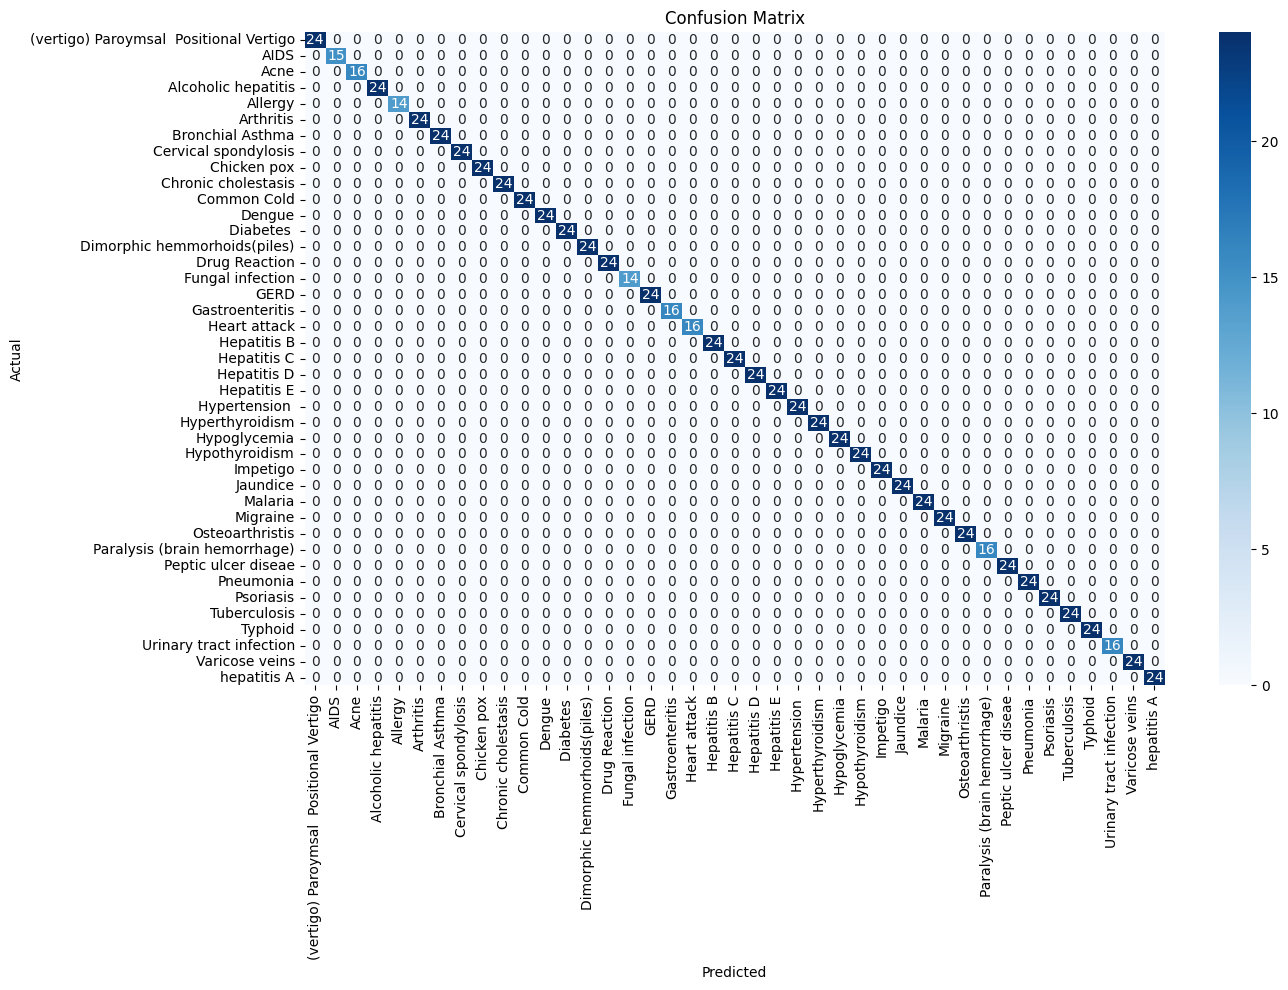

In [17]:
# Prediksi pada data test
y_pred = random_search_no_smote.predict(X_test_poly)

# Evaluasi
print(f"\n✅ Accuracy pada test set: {accuracy_score(y_test, y_pred):.4f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

labels = random_search_no_smote.best_estimator_.named_steps['clf'].classes_
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 📌 FEATURE IMPORTANCE

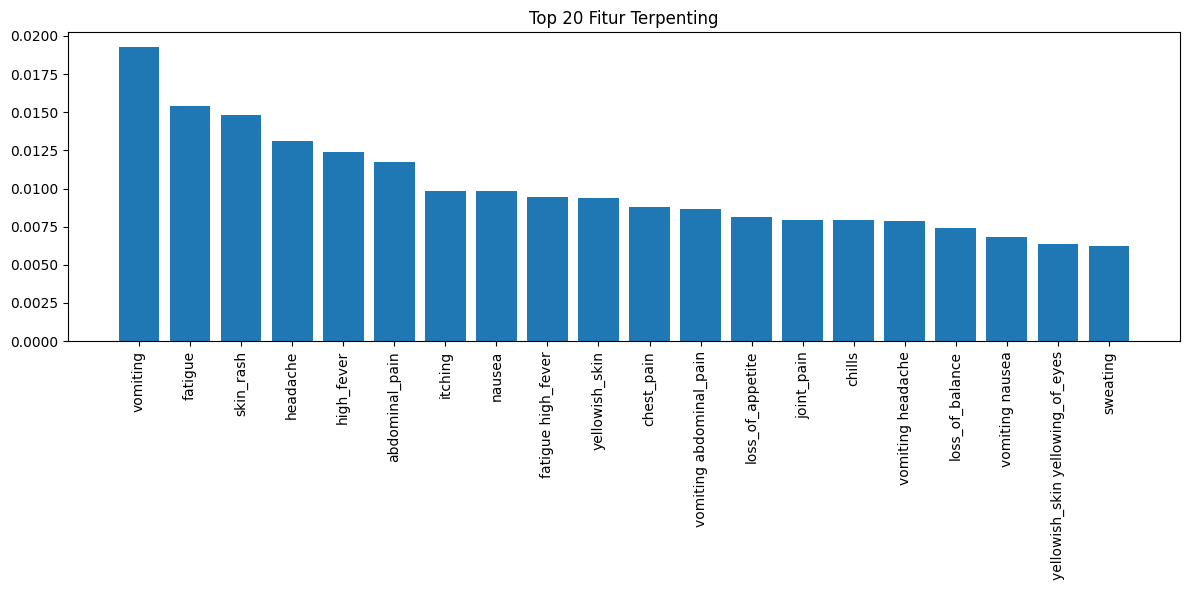

In [22]:
# Ambil mask fitur yang dipilih oleh SelectFromModel
selected_mask = random_search_no_smote.best_estimator_.named_steps['feature_sel'].get_support()

# Dapatkan nama fitur dari hasil polynomial features (pastikan poly sudah terdefinisi)
feature_names = np.array(poly.get_feature_names_out(symptom_columns))

# Pilih nama fitur yang terpilih
selected_features = feature_names[selected_mask]

# Ambil feature importances dari classifier
importances = random_search_no_smote.best_estimator_.named_steps['clf'].feature_importances_

# Urutkan indeks fitur berdasarkan importance descending
indices = np.argsort(importances)[::-1]

top_features = 20  # Jumlah fitur teratas yang ingin ditampilkan

plt.figure(figsize=(12, 6))
plt.title("Top 20 Fitur Terpenting")
plt.bar(range(top_features), importances[indices[:top_features]], align="center")
plt.xticks(range(top_features), selected_features[indices[:top_features]], rotation=90)
plt.tight_layout()
plt.show()


#  Simpan model ke file (joblib/pkl)

In [28]:
# Simpan model pipeline + preprocessing PolynomialFeatures
joblib.dump(random_search_no_smote.best_estimator_, 'model_pipeline_rf.pkl')
joblib.dump(poly, 'poly_features.pkl')

print("✅ Model dan preprocessing berhasil disimpan!")


✅ Model dan preprocessing berhasil disimpan!
